In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
from BlackJack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        p = [epsilon / nA for i in range(nA)]
        greedy_action = np.argmax(Q[observation])
        p[greedy_action] += 1 - epsilon
    return policy_fn

In [4]:
env.action_space.n

2

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for e in range(num_episodes):
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        
        d = False
        s = env.reset()
        s_list = []
        r_list = []
        a_list = []
        while not d:
            a = np.random.choice(range(env.action_space.n), p = policy(s))
            next_s, r, d, i = env.step(a)
            s_list.append(s)
            a_list.append(a)
            r_list.append(r)
            
            s = next_s
            
        total_r = 0
    
        for s, r, a in zip(s_list[::-1], r_list[::-1], a_list[::-1]):
            total_r = total_r * discount_factor + r
            returns_sum[(s, a)] += total_r
            returns_count[(s, a)] += 1
            
        for (s, a) in returns_sum:
            Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]
            
    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

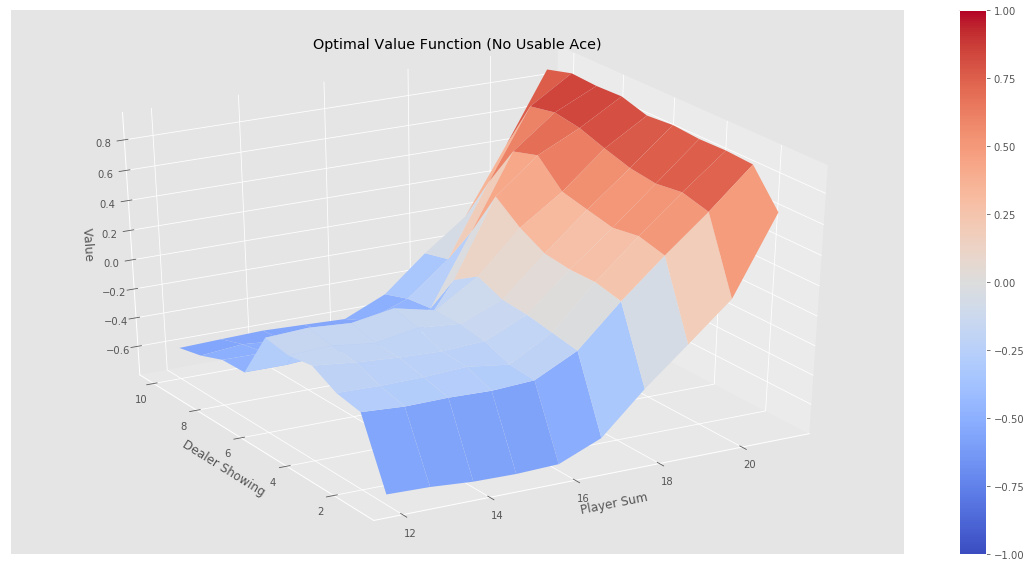

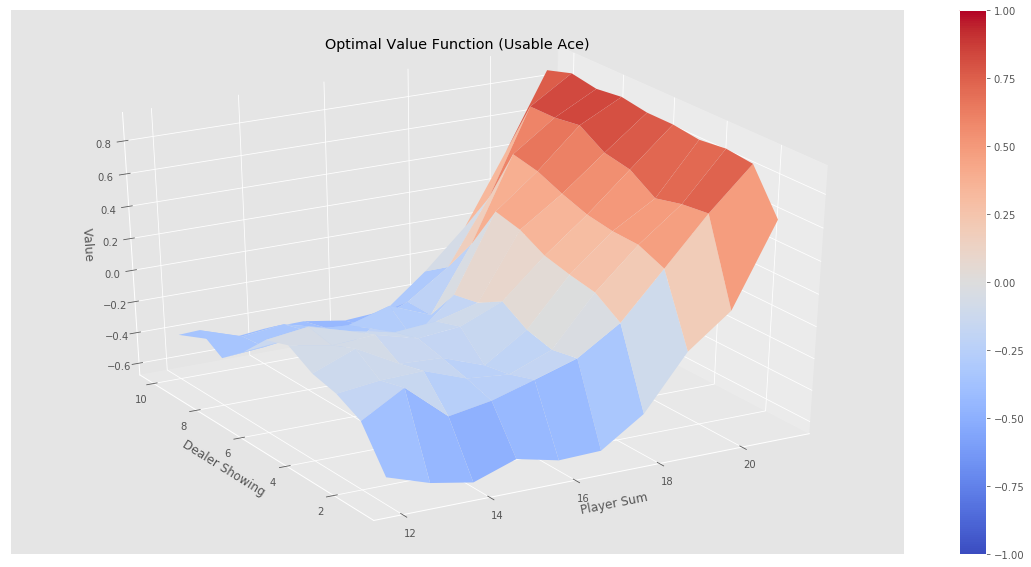

In [7]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [8]:
def fist_visit_mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for e in range(num_episodes):
        if e % 1000 == 0:
            print("\rEpisode {}/{}.".format(e, num_episodes), end="")
            sys.stdout.flush()
        
        d = False
        s = env.reset()
        s_list = []
        r_list = []
        a_list = []
        while not d:
            a = np.random.choice(range(env.action_space.n), p = policy(s))
            next_s, r, d, i = env.step(a)
            s_list.append(s)
            a_list.append(a)
            r_list.append(r)
            
            s = next_s
            
        total_r = 0
        r_discount_list = []
        for idx, r in enumerate(r_list[::-1]):
            total_r = total_r * discount_factor + r
            r_discount_list.append(total_r)
        r_discount_list = r_discount_list[::-1]
        
        
        visted_q = []
        for s, a, r in zip(s_list, a_list, r_discount_list):
            if (s, a) not in visted_q:
                returns_sum[(s, a)] += r
                returns_count[(s, a)] += 1
                visted_q.append((s, a))
            
        for (s, a) in returns_sum:
            Q[s][a] = returns_sum[(s, a)] / returns_count[(s, a)]
            
    return Q, policy

In [9]:
Q, policy = fist_visit_mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

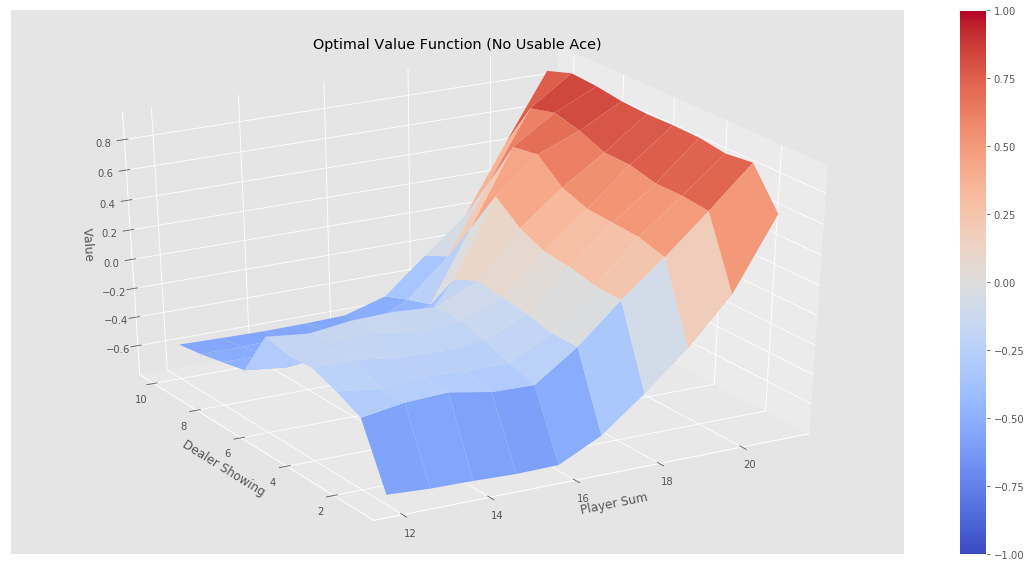

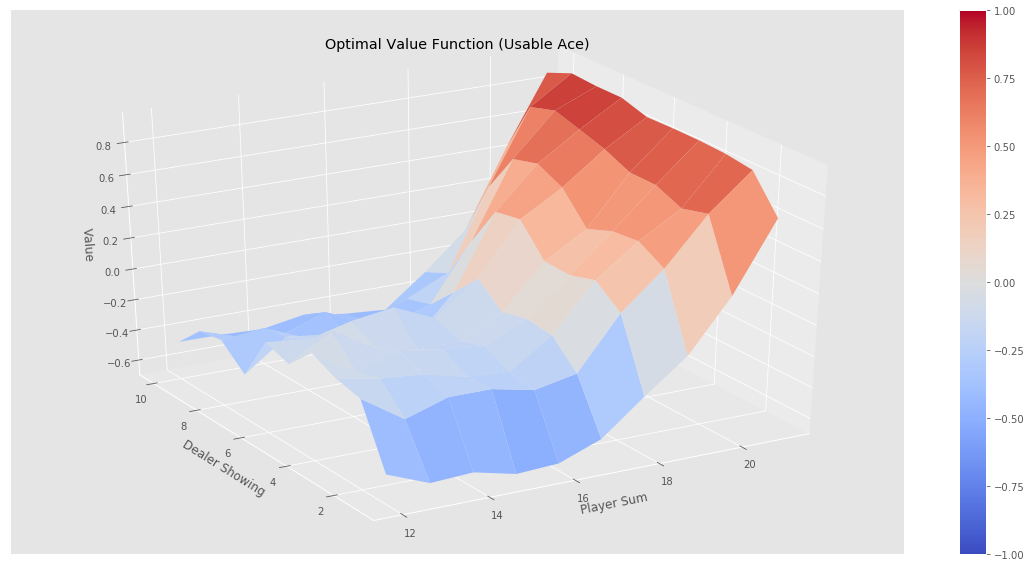

In [10]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")